In [12]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders 
from model import get_pretrained_emb, EncoderDecoder, EncoderRNN, DecoderRNN, Attention, DecoderAttnRNN
from train_eval import train_and_eval, inspect_model, count_parameters, summarize_results, \
    plot_single_learning_curve, load_experiment_log
import importlib
import pickle as pkl 

In [13]:
# model identification
MODEL_NAME = 'test_model'
SRC_LANG = 'vi'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 10 
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000
TARG_VOCAB_SIZE = 30000

# model architecture params 
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 300 
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 0.5
CLIP_GRAD_MAX_NORM = 10
ENC_DROPOUT = 0 # to actually implement
DEC_DROPOUT = 0 # to actually implement

# training params  
BATCH_SIZE = 32
NUM_EPOCHS = 5
LR = 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = True 

In [14]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [15]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [16]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, vocab)
limited_data = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 

In [17]:
# create dataloaders 
full_loaders = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
fast_loaders = create_dataloaders(limited_data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [18]:
# define model 

encoder = EncoderRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
decoder = DecoderRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                     targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                     pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
# decoder = DecoderAttnRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                          targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
#                          targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                          pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 

In [19]:
model, results = train_and_eval(
    model=model, full_loaders=full_loaders, fast_loaders=fast_loaders, params=params, vocab=vocab, 
    print_intermediate=True, save_checkpoint=True, lazy_eval=True, inspect=True, save_to_log=True, print_summary=True)

Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.24, Train BLEU: 0.00, Val BLEU: 0.26
Inspecting model on training data...
REFERENCE TRANSLATION: rachel pike : the science behind a climate headline in 4 minutes , atmospheric chemist rachel pike provides i &apos;d like to talk to you today about headlines that look like this when they have to they are both two branches of the same field
MODEL TRANSLATION: amplifications of of of of of of of of trumpet the the the it it it it it dizzy metallic of of of of of it it heirloom marriage the the of of it of of dizzy cowboy of of of of of of of
Inspecting model on validation data...
REFERENCE TRANSLATION: when i was little , i thought my country and i was very proud . in school , we spent a lot of time although i often wondered about the outside world , when i was seven years old , i saw
MODEL TRANSLATION: neuro-bunk ensler separated lobe of of it it it euphore euphore euphore euphore euphore euphore euphore euphore euphore standardized and it it of

In [20]:
summarize_results(load_experiment_log())

,dt_created,experiment_name,hyperparams,results,runtime,model_type,num_epochs,learning_rate,enc_hidden_dim,dec_hidden_dim,...,targ_lang,src_vocab_size,targ_vocab_size,src_max_sentence_len,targ_max_sentence_len,model_name,teacher_forcing_ratio,lazy_train,clip_grad_max_norm,val_loss
0,2018-11-26 23:17:44,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 8.783560848236084,...",53.518373,attention_bahdanau,10,0.0005,300,600,...,en,10000,10000,40,40,NaN,NaN,NaN,NaN,5.433290
1,2018-11-27 00:43:43,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 8.989323210716247,...",52.872075,attention_bahdanau,10,0.0005,300,600,...,en,10000,10000,40,40,NaN,NaN,NaN,NaN,5.436468
2,2018-11-27 02:28:19,test_run,"{'model_type': 'without_attention', 'num_epoch...","[{'epoch': 0.0, 'val_loss': 8.887566566467285,...",1.302775,without_attention,10,0.0005,300,600,...,en,10000,10000,40,40,NaN,NaN,NaN,NaN,7.335167
3,2018-11-27 02:30:44,test_run,"{'model_type': 'without_attention', 'num_epoch...","[{'epoch': 0.0, 'val_loss': 8.855473518371582,...",1.179587,without_attention,10,0.0005,300,600,...,en,10000,10000,40,40,NaN,NaN,NaN,NaN,7.390460
4,2018-11-27 05:10:18,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 8.919134140014648,...",155.873592,attention_bahdanau,1000,0.0005,300,600,...,en,10000,10000,40,40,NaN,NaN,NaN,NaN,7.484231
5,2018-11-28 00:43:37,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 10.040691375732422...",31.569452,attention_bahdanau,100,0.0005,300,600,...,en,30000,30000,40,40,NaN,NaN,NaN,NaN,7.985807
6,2018-11-28 13:52:27,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 10.062241554260254...",673.474022,attention_bahdanau,2000,0.0005,300,600,...,en,30000,30000,40,40,NaN,NaN,NaN,NaN,8.088548
7,2018-11-28 17:55:24,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 10.21630573272705,...",6.029234,attention_bahdanau,100,0.0005,300,600,...,en,30000,30000,10,10,NaN,NaN,NaN,NaN,8.507013
9,2018-12-01 02:29:11,test_model,"{'model_name': 'test_model', 'num_epochs': 5, ...","[{'epoch': 0.0, 'val_loss': 10.221494674682617...",0.312100,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,9.228798
8,2018-12-01 02:22:55,test_model,"{'model_name': 'test_model', 'num_epochs': 5, ...","[{'epoch': 0.0, 'val_loss': 10.231721878051758...",0.381173,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,NaN,9.330558


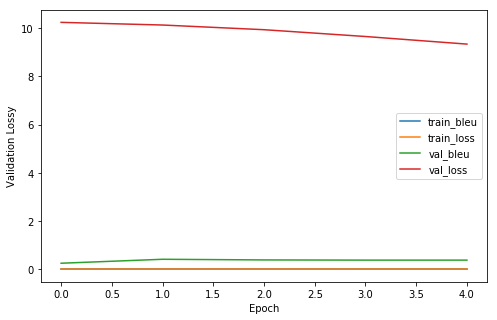

In [21]:
plot_single_learning_curve(results)